<a href="https://colab.research.google.com/github/Vmjkom/Intro_to_nlp_2021/blob/main/Projekti_Textual_Data_Analysis_on_Binary_Entity_Relations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

In this notebook implement a machine learning-based information extraction system that identifies binary relations stated to hold between specific named entities mentioned in the same sentence (e.g. PERSON founded ORGANIZATION). 

The projects is divided into three milestones:

 * Milestone 1: Manual relation annotation using texts and tool 
provided by course organizers.

 * Milestone 2: Implementation of machine-learning based method for relation extraction. 

 * Milestone 3: Large-scale application, assessment and and error analysis of method implemented in milestone 2.

Each group is expected to prepare a report on their work. Reports can be in any broadly supported format (e.g. PDF or Python notebook) and should include both the code implementing the project (separate .py files are OK) as well as a textual description of the project and its results.

The contribution of each member of the group should be varied across all the facets of the project, and the project report should include a statement on what the contribution of each member towards each milestone was.

Additional guidance from Discord:

"For milestone 2, the minimum for "completing" will be outperforming the majority baseline, which will hopefully not be particularly challenging. For the additional point, going the extra mile in terms like considering multiple metrics, models, or **input representations** and/or doing hyperparameter optimization count. For milestone 3, the minimum for "complete" is successfully applying the model to a larger set of new data and reporting some meaningful descriptive metrics about the result, and for the extra point e.g. error analysis or comparing different model variants will suffice. Basically, if you've successfully completed all milestones, can show effort beyond the minimum at each, and have written up your work in a reasonable way, you can expect to receive full points"

In [1]:
# imports 
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
!pip -q install datasets

### Relation extraction system task formulation

This description of ML task formulation is from UTU Textual Data analysis [course material](https://colab.research.google.com/github/TurkuNLP/Text_Mining_Course/blob/master/Relation%20extraction.ipynb#scrollTo=PKjG5UlObCZs)

Given manually annotated examples where each consists of

* Document text $d$
* Two entity mentions in that document, $m_1$ and $m_2$
* Relation type (e.g. `employee`) or `NONE` to signify no relation

relation extraction can be formulated as a classification task by creating an representation of the mentions $m_1$ and $m_2$ in their context ($d$) as input and the relation type (or `NONE`) as output. (Note that this assumes at most one relation type holds per entity pair.)

In previous state-of-the-art approaches, considerable effort was invested into creating representations of the mentions in context for ML methods, frequently involving e.g. carefully engineered representations of dependency paths.

Fortunately for us, with recent Transformer-based approaches such as BERT, these representations can be simplified into marking the entities in the original text in some way, and providing the text with marked entities to the model as input.

For example, given

* Document text $d$ = `Bill Gates and Paul Allen founded Microsoft`
* Mentions $m_1$ = `(0, 10, PERSON, Bill Gates)` and $m_2$ = `(34, 43, ORG, Microsoft)`
* Relation type `founder`

We could formulate the classification example e.g. as

* input: `PERSON and Paul Allen founded ORGANIZATION`
* output: `founder`

Here using the literal type strings `PERSON` and `ORGANIZATION` to mark the two mentions under consideration. (Note that other mentions in context are not marked.)

(**Project work** As the course project involves implementing a relation extraction system along the lines outlined above, we will not provide an implementation here. You may find the previously covered notebooks on text classification helpful as references for your implementation.)

Machine learning means the "rules" for solving the given task are learned from examples, they are not explicitly written.

# MS 2 starts here

In [3]:
!wget -q -nc http://dl.turkunlp.org/TKO_8964_2021/PER-ORG-relations-combined-exercise.tsv

In [4]:
#pd.set_option('display.max_colwidth', None)

def open_file(file):
  df = pd.read_csv(file, sep='\t', header=None)
  df = df.rename(columns={0: 'id', 1: 'label', 2: 'document'})
  df = df.drop('id', axis=1)
  return df

data = open_file('PER-ORG-relations-combined-exercise.tsv')
# data.head(5)

In [50]:
print(train_test_valid_dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'document'],
        num_rows: 2169
    })
    test: Dataset({
        features: ['label', 'document'],
        num_rows: 302
    })
    valid: Dataset({
        features: ['label', 'document'],
        num_rows: 301
    })
})


# Explore the data

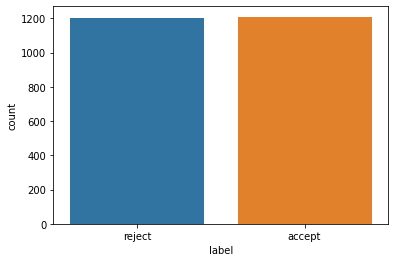

In [5]:
data.groupby(['label']).count()

sns.countplot(data=data, x='label');

Some words about the data quality?

In [55]:
# We have these classes in the data
labels=(data['label'])
print(type(labels))

<class 'pandas.core.series.Series'>


In [ ]:
for i in range(10):
  print(data['label'][i], '\t', data['document'][i])
  print()

In the input data "documents" we can see the tags signaling named entities:


*   `<ORG> ORGANISATION </ORG>`
*   `<PERSON> PERSON </PERSON>`

These NER (Named Entity Recognition) tags are used in language modeling to recognize permanent entities and relations between them. 

#Preprocessing the data

## Handilng the tags and the tokens

### Approach 1

In [8]:
import re

pattern_person = r"<PERSON>.+</PERSON>" # .+ Matches one or more any charachter
docs = [re.sub(pattern_person, "PERSON", item) for item in data['document']]

pattern_org = r"<ORG>.+</ORG>" # .+ Matches one or more any charachter
docs = [re.sub(pattern_org, "ORG", item) for item in docs]

for i in range(0,200,100):
  print(data['document'][i])
  print(docs[i])
  print()
  # break

Wedell 's company , <ORG>the Wedell - Williams Air Service Corporation</ORG> , won 14 `` distinguished finishes `` ( top five ) in the <PERSON>Thompson</PERSON> and Bendix Trophy races .
Wedell 's company , ORG , won 14 `` distinguished finishes `` ( top five ) in the PERSON and Bendix Trophy races .

In 1949 , <PERSON>Bardot</PERSON> was accepted at <ORG>the Conservatoire de Paris</ORG> .
In 1949 , PERSON was accepted at ORG .



In [ ]:
# for i in data['document'][1]:
#   print(i)

### Approach 2

The data needs to be something like?: 

`'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']`

`'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]`

In [ ]:
one = data['document'][4]
print(one)

The Lima-based newspaper `` Perú 21 `` ran an editorial noting that even though the <ORG>Universidad de Lima</ORG> poll results indicate that four out of every five interviewees believe that <PERSON>Fujimori</PERSON> is guilty of some of the charges against him , he still enjoys at least 30 % of popular support and enough approval to restart a political career .


In [ ]:
org_start=0
org_end=0

per_start=0
per_end=0

tokens=one.split(" ")
tags = ["O"] * len(tokens) # initialize tags: all O at the start
print(tokens)

for i, t in enumerate(tokens):
  if t.startswith("<ORG>"):
    org_start=i # starting index (B) of multitoken ORG tag
    tags[i]="B_ORG" # replace a tag 
    tokens[i]=re.sub(r"<ORG>", "", t) # remove tag from the tokens
  if t.endswith("</ORG>"):
    org_end=i # ending index of multitoken ORG tag
    tokens[i]=re.sub(r"</ORG>", "", t) # remove tag from the tokens
  # all the same but for PER tags instead of ORG tags
  if t.startswith("<PERSON>"):
    per_start=i
    tags[i]="B_PER"
    tokens[i]=re.sub(r"<PERSON>", "", t)
  if t.endswith("</PERSON>"):
    per_end=i
    tokens[i]=re.sub(r"</PERSON>", "", t)

# use the indices collected above to set the in (I) tags
org_indexes=list(range(org_start+1, org_end+1))
if not org_indexes: # if no indices (i.e. token to be tagged is single)
  tokens[org_start]=re.sub(r"<ORG>", "", tokens[org_start]) # just fix the token
else:
  for index in org_indexes:
    tags[index] = "I_ORG"

# all the same but for PER tags instead of ORG tags
per_indexes=list(range(per_start+1, per_end+1))
if not per_indexes: 
  tokens[per_start]=re.sub(r"<PERSON>", "", tokens[per_start])
for index in per_indexes:
    tags[index] = "I_PER"

for tag, token in zip(tags, tokens):
  print(tag, "\t",token)

['The', 'Lima-based', 'newspaper', '``', 'Perú', '21', '``', 'ran', 'an', 'editorial', 'noting', 'that', 'even', 'though', 'the', '<ORG>Universidad', 'de', 'Lima</ORG>', 'poll', 'results', 'indicate', 'that', 'four', 'out', 'of', 'every', 'five', 'interviewees', 'believe', 'that', '<PERSON>Fujimori</PERSON>', 'is', 'guilty', 'of', 'some', 'of', 'the', 'charges', 'against', 'him', ',', 'he', 'still', 'enjoys', 'at', 'least', '30', '%', 'of', 'popular', 'support', 'and', 'enough', 'approval', 'to', 'restart', 'a', 'political', 'career', '.']
O 	 The
O 	 Lima-based
O 	 newspaper
O 	 ``
O 	 Perú
O 	 21
O 	 ``
O 	 ran
O 	 an
O 	 editorial
O 	 noting
O 	 that
O 	 even
O 	 though
O 	 the
B_ORG 	 Universidad
I_ORG 	 de
I_ORG 	 Lima
O 	 poll
O 	 results
O 	 indicate
O 	 that
O 	 four
O 	 out
O 	 of
O 	 every
O 	 five
O 	 interviewees
O 	 believe
O 	 that
B_PER 	 Fujimori
O 	 is
O 	 guilty
O 	 of
O 	 some
O 	 of
O 	 the
O 	 charges
O 	 against
O 	 him
O 	 ,
O 	 he
O 	 still
O 	 enjoys
O 	 at
O 	

### Approach 3

The data needs to be something like?: 

`'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']`

`'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]`

Any hints for preparing the data?

FinBERT was trained with:

Teemu Ruokolainen, Pekka Kauppinen, Miikka Silfverberg,
and Krister Lind´en. 2019. A Finnish news
corpus for named entity recognition. Language Resources
and Evaluation, pages 1–26.

Link to the article: https://arxiv.org/pdf/1908.04212.pdf

available at: https://github.com/mpsilfve/finer-data

Tags: BIO + NER:

Irlannin	B-ORG

hallitus	I-ORG	


In [ ]:
# # import re

# # print(data['document'][0])

# per_start = r"<PERSON>" 
# testing = [re.sub(per_start, "<PERSON> ", item) for item in data['document']]
# per_end = r"</PERSON>" 
# testing = [re.sub(per_end, " </PERSON>", item) for item in testing]

# org_start = r"<ORG>" 
# testing = [re.sub(org_start, "<ORG> ", item) for item in testing]
# org_end = r"</ORG>" 
# testing = [re.sub(org_end, " </ORG>", item) for item in testing]

# # pattern_org = r"<ORG>.+</ORG>" # .+ Matches one or more any charachter
# # testing = [re.sub(pattern_org, "ORG", item) for item in testing]

# for line in testing:
#   tags=[]
#   tokens=[]
#   words = line.split(" ")
#   print(words)
#   for index, word in enumerate(words):
#     if word == "<PERSON>":
#       tags.append("B_PER")
#     # if word != "</PERSON>":
#     #   tags.append("I_PER")
#       while word != "</PERSON>":
#         tags.append("I_PER")
#         tokens.append(word)
#     if word is "</PERSON>":
#       continue   
#     if word is "<ORG>":
#       tags.append("B_ORG")
#       while word is not "</ORG>":
#         tags.append("I_ORG")
#         tokens.append(word)
#     else: 
#       tags.append("O")
#       tokens.append(word)
#     # if word not in ["<PERSON>", "</PERSON>", "<ORG>", "</ORG>"]:
#     #   print(word)
#     #   tags.append("O")
  
#   break

# for token, tag in zip(tokens, tags):
#   print(tag, "\t", token)


['Wedell', "'s", 'company', ',', '<ORG>', 'the', 'Wedell', '-', 'Williams', 'Air', 'Service', 'Corporation', '</ORG>', ',', 'won', '14', '``', 'distinguished', 'finishes', '``', '(', 'top', 'five', ')', 'in', 'the', '<PERSON>', 'Thompson', '</PERSON>', 'and', 'Bendix', 'Trophy', 'races', '.']


In [ ]:

# tags=[]
# tokens=[]

# # list.insert(index, elem) -- inserts the element at the given index, shifting elements to the right.
# line=testing[0]

# words = line.split(" ")
# # keep=words.copy() # remove form this
# print(words)
# print()
# for index, word in enumerate(words):
#   if word == "<ORG>":
#     # del keep[index]
#     tags.append("B_ORG")
#   if word == "</ORG>":
#     # del keep[index]
#     # tags.append("B_ORG")
#     # continue
#   else: 
#     tags.append("O")
#     tokens.append(word)
# # print(tags)
# # print(tokens)

# for token, tag in zip(tokens, tags):
#   print(tag, "\t", token)

### UDPipe?

- Machine learned tokenizer and segmenter

In [ ]:
# %%bash
# wget -nc -q https://github.com/TurkuNLP/intro-to-nlp/raw/master/Data/en.segmenter.udpipe
# #wget -nc https://github.com/UniversalDependencies/UD_Finnish-TDT v.2.2
# pip3 install ufal.udpipe

In [ ]:

# # Documentation: https://ufal.mff.cuni.cz/udpipe/users-manual
# import ufal.udpipe as udpipe

# model = udpipe.Model.load("en.segmenter.udpipe")
# pipeline = udpipe.Pipeline(model,"tokenize","none","none","horizontal") # horizontal: returns one sentence per line, with words separated by a single space

# segmented_document = pipeline.process(test_input)

# print(segmented_document)

Nope, not like this!

## Train test split 

https://github.com/HannaKi/Textual-Data-Analysis-UTU/blob/master/train_bert_for_ner_exercise.ipynb

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(docs, data['label'], test_size=0.33) # treeni ja testidata

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33) # jaetaan testidata vielä kertaalleen, jotta saadaan validointdata

In [53]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [59]:
panda = pd.DataFrame(list(zip(docs, labels)),
               columns =['text', 'label'])

#temp = pd.Dataframe(data=docs)

In [80]:
from datasets import Dataset,DatasetDict
dataset = Dataset.from_pandas(panda)

#
train_test = dataset.train_test_split(test_size=0.3)
testi_data = train_test['test'].train_test_split(test_size=0.2)
train_test_valid_dataset = DatasetDict({
    'train': train_test['train'],
    'development': testi_data['test'],
    'test': testi_data['train']})


In [81]:
print(train_test_valid_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1687
    })
    development: Dataset({
        features: ['text', 'label'],
        num_rows: 145
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 579
    })
})


In [ ]:
for teksti in 

In [10]:
print(len(X_train), len(X_test), len(X_val))

print(len(y_train), len(y_test), len(y_val))


1615 533 263
1615 533 263


In [19]:
for rivi in X_train[:5]:
  print(rivi)

In December 1946 , ORG ( DST ) , led by commando and counter - insurgency expert Captain PERSON , were accused of pacifying the southern Sulawesi region using arbitrary terror techniques , which were copied by other anti-Republicans .
In recent years , PERSON hosted the ORG baseball tournament ( 2001–2009 ) and the National Club Baseball Association World Series ( 2015 and 2016 ) .
In 1612 , PERSON introduced ORG , a constellation representing a bee .
Other probable sources of inspiration for `` Candide `` are ( 1699 ) by PERSON and ( 1753 ) by ORG .
In mainland China , People 's Republic of China was established by ORG , with PERSON as its state chairman .


## Data to datasets.Dataset format

In [11]:
!pip --quiet install datasets

In [12]:
from datasets import load_dataset, Dataset

id=[1,2]
texts=[]
tags=[]

t1=['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
texts.append(t1)
t2=['Germany', "'s", 'representative', 'to', 'the', 'European', 'Union', "'s", 'veterinary', 'committee', 'Werner', 'Zwingmann', 'said', 'on', 'Wednesday', 'consumers', 'should', 'buy', 'sheepmeat', 'from', 'countries', 'other', 'than', 'Britain', 'until', 'the', 'scientific', 'advice', 'was', 'clearer', '.']
texts.append(t2)

tag1=[3, 0, 7, 0, 0, 0, 7, 0, 0]
tags.append(tag1)
tag2=[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0]
tags.append(tag1)

In [13]:
m_dict={}
m_dict['id']=id
m_dict['texts']=texts
m_dict['tags']=tags

In [14]:
splitit={}
splits['train']=

SyntaxError: ignored

In [15]:
dat = Dataset.from_dict(m_dict)
print(dat)

Dataset({
    features: ['id', 'texts', 'tags'],
    num_rows: 2
})


## Load tokenizer and tokenize data

We'll load an appropriate tokenizer for the pre-trained model with [`AutoTokenizer.from_pretrained`](https://huggingface.co/transformers/model_doc/auto.html#transformers.AutoTokenizer.from_pretrained). 

!!!(We request a ["fast" tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html) as it provides a mapping from tokens to input words, which we need for NER.)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME),# use_fast=True) 


In [ ]:
def encode_dataset(d):
  return tokenizer(d['sentence'])

encoded_dataset = dataset.map(encode_dataset) #tokenize all of the data

In [ ]:
tokenizer(test_input)

Tokenze all the splits

## Model preparation stuff here

In [ ]:
!pip --quiet install transformers
!pip --quiet install datasets
!pip --quiet install seqeval

Find a Finnish BERT model in the Hugging Face model repository and the Turku NER corpus in the dataset repository.

Take care that the model is case-sensitive (cased or not). 

Case sensitive: words starting with capital letters are not the same as words with lower case: House != house)
    
- Model: TurkuNLP/bert-base-finnish-cased-v1: https://huggingface.co/TurkuNLP/bert-base-finnish-cased-v1
- Data: turku_ner_corpus https://huggingface.co/datasets/turku_ner_corpus


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import DataCollatorForTokenClassification
from datasets import load_dataset, load_metric


MODEL_NAME = 'TurkuNLP/bert-base-finnish-cased-v1'
DATASET = 'turku_ner_corpus'
MAX_LENGTH=128 # ?
DUMMY_LABEL_ID = -100    # Don't change this!

train_args = TrainingArguments(
    'output_dir',
    save_strategy='no',
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    learning_rate=1e-5, # --> 0.00001
    per_device_train_batch_size=32, # 4
    num_train_epochs=2, #1
)

# complementary things: increase learning rate, decrease batch size

What should the data set look like?

In [ ]:
from datasets import load_dataset, load_metric


In [ ]:
dataset = load_dataset(DATASET)
label_list = dataset["train"].features['ner_tags'].feature.names
num_labels = len(label_list)

NameError: ignored

In [ ]:
dataset

In [ ]:
train=dataset['train']
for i in range(0, 200, 5):
  print(train[i])

In [ ]:
test_input=data['document'][i] # 1st input text
print(test_input)
type(test_input)

## Load pre-trained model

Next, we'll load the pre-trained model (especially the weights!) with support for text classification output using [`AutoModelForSequenceClassification.from_prertained`](https://huggingface.co/transformers/model_doc/auto.html#transformers.AutoModelForSequenceClassification.from_pretrained).

Note that we need to provide the number of labels in the data when loading the model.

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

TODO: Training and validation accuracy (some fancy plots maybe) --> choose the best model (best hypearparameters)

# MS 3


## test accuracy

precision and recall, F-score